# Yusuf Britton, data wrangling with @WeRateDogs

In [1]:
#Standard libs for data analysis
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import matplotlib.dates #setting dates for xticks

#JSON handling
import json

# Database connection
from sqlalchemy import create_engine
from sqlalchemy.types import Integer
from sqlalchemy.types import String
from sqlalchemy.types import Float

#Image handlimg
from PIL import Image
from IPython.display import display #Used to display images loaded from PIL
import os
import requests

#Misc
import pprint
import re #Python Regular expression, used for dog name 
import datetime #handling datetime series

## Gather

In [2]:
#Loading in data
dogs_df = pd.read_csv('twitter-archive-enhanced.csv')

Loading in the image data to determine if an image is a dog and what type of dog it is

In [3]:
#Tab seperated file
#Use file to determine what is a dog and what type of dog
image_df = pd.read_csv('image-predictions.tsv', sep= "\t")

To convert a JSON to a dataframe, we will use the json.loads method then append it to a list. The list of dict items will be converted into a dataframe.

This JSON data was gather from Twitter's API (https://developer.twitter.com) , using key and access tokens to wrangle tweet information from the WeRateDogs twitter archive

In [4]:
#Parsing JSON file into a python list with nested data structures.
additional_tweet_data = []

with open('tweet_json.txt') as json_file:
    for line in json_file: #Each line is a JSON with nested values
        json_data = json.loads(line) #This is loading in the JSON
        tweet_id = json_data['id']
        retweet_count = json_data['retweet_count']
        favorite_count = json_data['favorite_count']
        additional_tweet_data.append({'retweet_count': int(retweet_count),
                       'favorite_count': int(favorite_count),
                       'tweet_id': tweet_id})
        

#This contains the JSON tweet id, retweet, and favorite counts to append to dogs_df for these omited columns 
add_tweet_df = pd.DataFrame(additional_tweet_data, columns = ['tweet_id', 'retweet_count', 'favorite_count'])

## Assess
At the end of this section, I will list all of the issues found in the datasets

### dogs_df

<b>Visual Assessment</b>

First, we will load some of the information from the `dog_df` dataframe

In [5]:
dogs_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


There are NAN values in these columns: `in_reply_to_status_id`, `in_reply_to_user_id`, `retweeted_status_id`, `retweeted_status_user_id`, `retweeted_status_timestamp`.

From opening the document in excel, some of the values in the `name` column had missing values

There are multiple URLs in the `expanded_urls`, some of which are not from WeRateDogs

`timestamp` should be converted to datetime, but I actually would like to view just the year

<b>Programmic Assessment</b>

In [6]:
dogs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

From looking at the at `info()`, the same fields mentioned in the visual assessment are missing a majority of it's values.

Also, there are some missing URLS

<b>Replies and retweets</b>

Looking up the Twitter API Docs, I was able to determine some information about the dataset:
>in_reply_to_status_id: Nullable. If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID

>retweeted_status_id: Users can amplify the broadcast of Tweets authored by other users by retweeting ...

Because the objective is to only view original post, any observations that are replies or retweets will be removed from the dataset

Document reference:
(https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object.html)

<b>Dog types</b>

Checking to see what how many type of dog types there are.

In [7]:
#Printing dogs that we know of
print("Doggos: ",dogs_df.doggo.value_counts()[1]) 
print("Floofer: ",dogs_df.floofer.value_counts()[1]) 
print("Pupper: ",dogs_df.pupper.value_counts()[1]) 
print("Puppo: ",dogs_df.puppo.value_counts()[1])

#aggregrating le Dogges
known_dogs = sum([dogs_df.doggo.value_counts()[1],dogs_df.floofer.value_counts()[1],
                 dogs_df.pupper.value_counts()[1], dogs_df.puppo.value_counts()[1]])

print("We indentified",known_dogs,"dogs, but we are missing", 
      dogs_df.doggo.count() - known_dogs,"dog types!")

Doggos:  97
Floofer:  10
Pupper:  257
Puppo:  30
We indentified 394 dogs, but we are missing 1962 dog types!


We may not be able to get all the dog types based on the information available. Also, this seems to be subjective to the OPs discretion (personally, I think they are all puppos, but that just me 😜)

In [8]:
dogs_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


<b>Denominator</b>

Looking at `describe()`, the max demonitor of 170 is pretty high since a majority of the column concentrates around 10.

Also, there seems to be some that has a values that are zero, so we should look for values that aren't 10



In [9]:
#number of observations with denominators are not 10
dogs_df.query("rating_denominator != 10").shape[0]

23

In [10]:
dogs_df.query("rating_denominator != 10")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
342,832088576586297345,8.320875e+17,3.058208e+07,2017-02-16 04:45:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@docmisterio account started on 11/15/15,NaN,NaN,NaN,NaN,11,15,None,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1120,731156023742988288,NaN,NaN,2016-05-13 16:15:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to this unbelievably well behaved sq...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/731156023...,204,170,this,None,None,None,None
1165,722974582966214656,NaN,NaN,2016-04-21 02:25:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Happy 4/20 from the squad! 13/10 for all https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/722974582...,4,20,None,None,None,None,None
1202,716439118184652801,NaN,NaN,2016-04-03 01:36:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bluebert. He just saw that both #Final...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/716439118...,50,50,Bluebert,None,None,None,None


There are 23 instances denominators that are not 10. This will be cleaned in a later.

### image_df

<b>Visual Assessment</b>

In [11]:
image_df

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


There are some false values in all `p_dog` section that determine if it is a dog.

<b>Programmic Assessment</b>

In [12]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Though we could convert tweet_id into a string, everything else in `info()` looks good.

In [13]:
image_df.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


`describe()` looks okay

### add_tweet_df

In [14]:
add_tweet_df

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8360,38183
1,892177421306343426,6174,32738
2,891815181378084864,4085,24655
3,891689557279858688,8501,41508
4,891327558926688256,9194,39684
5,891087950875897856,3060,19926
6,890971913173991426,2028,11651
7,890729181411237888,18542,64402
8,890609185150312448,4199,27371
9,890240255349198849,7260,31419


This contains the retweet and favorite counts from the dog_df, but it seems to have less observations. Will look into this in the Programmic Assessment.

<b>Programmic Assessment</b>

In [15]:
add_tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 3 columns):
tweet_id          2342 non-null int64
retweet_count     2342 non-null int64
favorite_count    2342 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


### Data issues

#### Quality Issues
`All`
- tweet_id should be a string, not a int

`dogs_df`
- timestamp should be converted to datetime
- Some tweets are replies 
- Some tweets are retweets
- Missing URLS
- Incorrect URLs
- Some dogs names are missing or incorrect (the, a, an, etc) 
- Incorrect values in rating numerators
- Demoninator values not 10
- If Demoninators are changed, Numerator need adjustment 


`image_df`
- Contain non-dog types
- Filter dogs_df by indentified dogs
- Dog boolean, species, and prob names arn't descriptive

#### Tidy Issues
`dogs_df`
- Multiple dog types

`image_df`
- Move image url column into dogs_df

`add_tweet_df`
- Combine this dataset with dogs_df

## Clean

In [16]:
#Making copies of datasets
dogs_df_clean = dogs_df.copy()
image_df_clean = image_df.copy()
add_tweet_df_clean = add_tweet_df.copy()

<b>Define</b>

`dogs_df_clean`: extracting year from datetime to use for analysis

For analysis, we will use a year-month

<b>Code</b>

In [17]:
#converting to datetime
dogs_df_clean.timestamp = pd.to_datetime(dogs_df_clean['timestamp'])


#extracting years
dogs_df_clean['year'] = pd.DatetimeIndex(dogs_df_clean['timestamp']).year

#extracting period
dogs_df_clean['period'] = pd.to_datetime(dogs_df_clean['timestamp']).dt.to_period('M')


# In future analysis, can use to this produce an object of year-month (example 2018-05)
# dogs_df_clean.timestamp = pd.to_datetime(dogs_df_clean['timestamp']).dt.to_period('M')


<b>Test</b>

In [18]:
dogs_df_clean.year.value_counts()

2016    1183
2015     690
2017     483
Name: year, dtype: int64

<b>Define</b>

`dogs_df_clean`: tweet_id should be a string, not a int

`tweet_id` is the unique indentifier for the three data frames, so converting to a str

<b>Code</b>

In [19]:
dogs_df_clean.tweet_id = dogs_df_clean.tweet_id.astype('str')
image_df_clean.tweet_id = image_df_clean.tweet_id.astype('str')
add_tweet_df_clean.tweet_id = add_tweet_df_clean.tweet_id.astype('str')

<b>Test</b>

From looking at the `info()`, columns pertaining to replies and retweets are 0.

In [20]:
#Checking dtypes of each series. originally ints, they are now O (object, string in pandas)
dogs_df_clean.tweet_id.dtype, image_df_clean.tweet_id.dtype, add_tweet_df_clean.tweet_id.dtype

(dtype('O'), dtype('O'), dtype('O'))

<b>Define</b>

`dogs_df_clean`: Removing tweets that are replies and retweets

One of the steps would be replacing the replies/retweets with the original quotes, but from visiting some of the URLs, it seems to be inconsistant. Some of the original qoutes have rates, while others don't.

Because of time constrictions for this project, choosing to drop these types of tweets. Will come back to this analysis in the future.

<b>Code</b>

In [21]:
# Storing replies and retweets indices as a list
dropped_id = list(dogs_df_clean.query("in_reply_to_status_id != 'Nan' or retweeted_status_id != 'Nan'").index)

In [22]:
# Dropping both from dogs_df_clean
dogs_df_clean = dogs_df_clean.drop(dropped_id)

<b>Test</b>

From looking at the `info()`, columns pertaining to replies and retweets are 0.

In [23]:
dogs_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2097 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null datetime64[ns]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
year                          2

In [24]:
# removing 0 columns
dogs_df_clean = dogs_df_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 
                              'retweeted_status_user_id', 'retweeted_status_timestamp'], axis = 1)

In [25]:
dogs_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 14 columns):
tweet_id              2097 non-null object
timestamp             2097 non-null datetime64[ns]
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  2097 non-null object
doggo                 2097 non-null object
floofer               2097 non-null object
pupper                2097 non-null object
puppo                 2097 non-null object
year                  2097 non-null int64
period                2097 non-null object
dtypes: datetime64[ns](1), int64(3), object(10)
memory usage: 245.7+ KB


<b>Define</b>

`dogs_df_clean`: Using Correct URLS for missing and incorrect values

There are values that are blank, contain multiple URLS, or redirects to a non-WeRateDogs URL.

The pattern for WeRateDogs is "https://twitter.com/dog_rates/status/(tweet_id)". Appending this to the column

<b>Code</b>

In [26]:
#Replacing URLS with WeRateDogs URL
dogs_df_clean['expanded_urls'] = "https://twitter.com/dog_rates/status/" + dogs_df_clean['tweet_id']

<b>Test</b>

In [27]:
dogs_df_clean['expanded_urls'].head()

0    https://twitter.com/dog_rates/status/892420643...
1    https://twitter.com/dog_rates/status/892177421...
2    https://twitter.com/dog_rates/status/891815181...
3    https://twitter.com/dog_rates/status/891689557...
4    https://twitter.com/dog_rates/status/891327558...
Name: expanded_urls, dtype: object

<b>Define</b>

`dogs_df_clean`: Correcting dog names

Aside from the prepositions, there is one dog name O'Malley that needs to be correct (entered as "O")

<b>Code</b>

In [28]:
#Displaying rows where "named" is in text column and name column contains a lowercase word
dogs_named_df = dogs_df_clean.loc[(dogs_df_clean['name'].str.islower()) & (dogs_df_clean['text'].str.contains('named'))]

#Displaying rows where "name is" is text column and name column contains a lowercase word
dogs_name_is_df = dogs_df_clean.loc[(dogs_df_clean['name'].str.islower()) & (dogs_df_clean['text'].str.contains('name is'))]

#After the "named" and "name is" is corrected, this is used to pick up the remaining names
dogs_nan_name_df = dogs_df_clean.loc[(dogs_df_clean['name'].str.islower())]

# Saved text series as python list for iteration
named_list = dogs_named_df['text'].tolist()
name_is_list = dogs_name_is_df['text'].tolist()
nan_list = dogs_nan_name_df['text'].tolist()

In [29]:
# using names after "named" in text column
for tweet_text in named_list:
    mask = dogs_df_clean.text == tweet_text #Finding instances that master df equals sample
    dogs_df_clean.loc[mask, 'name'] = re.findall(r"named\s(\w+)", tweet_text) #return back (\w+), the name

# using names after "name is" in text column
for tweet_text in name_is_list:
    mask = dogs_df_clean.text == tweet_text
    dogs_df_clean.loc[mask, 'name'] = re.findall(r"name is\s(\w+)", tweet_text)    

# For all other instances of incorrect names without names, setting incorrect names with None
for tweet_text in nan_list:
    mask = dogs_df_clean.text == tweet_text
    dogs_df_clean.loc[mask, 'name'] = 'None'
    

https://docs.python.org/2/library/re.html used parentheses to return back a regex

In [30]:
# Correcting O'Malley
dogs_df_clean.name = dogs_df_clean.name.replace("O", "O'Malley")

<b>Test</b>

In [31]:
dogs_df_clean.loc[(dogs_df_clean['name'].str.islower())]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,year,period


In [32]:
dogs_df_clean.loc[(dogs_df_clean['name']) == "O'Malley"]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,year,period
775,776201521193218049,2016-09-14 23:30:38,"<a href=""http://twitter.com/download/iphone"" r...",This is O'Malley. That is how he sleeps. Doesn...,https://twitter.com/dog_rates/status/776201521...,10,10,O'Malley,None,None,None,None,2016,2016-09


<b>Define</b>
`dogs_df_clean`: updating incorrect numerators


<b>Code</b>

In [33]:
# Updating numerator using regex in text column
dogs_df_clean.rating_numerator = (dogs_df_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)[0]).astype('float64')
dogs_df_clean

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,year,period
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,None,None,None,2017,2017-08
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,None,None,None,2017,2017-08
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,None,None,None,2017,2017-07
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,None,None,None,2017,2017-07
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None,None,None,None,2017,2017-07
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13.0,10,None,None,None,None,None,2017,2017-07
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,https://twitter.com/dog_rates/status/890971913...,13.0,10,Jax,None,None,None,None,2017,2017-07
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13.0,10,None,None,None,None,None,2017,2017-07
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13.0,10,Zoey,None,None,None,None,2017,2017-07
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14.0,10,Cassie,doggo,None,None,None,2017,2017-07


<b>Test</b>

In [34]:
dogs_df_clean.describe()

,rating_numerator,rating_denominator,year
count,2097.000000,2097.000000,2097.000000
mean,12.147725,10.448736,2015.860277
std,40.338978,6.645061,0.691435
min,0.000000,2.000000,2015.000000
25%,10.000000,10.000000,2015.000000
50%,11.000000,10.000000,2016.000000
75%,12.000000,10.000000,2016.000000
max,1776.000000,170.000000,2017.000000


In [35]:
dogs_df_clean.rating_numerator.value_counts()

12.00      486
10.00      436
11.00      413
13.00      287
9.00       153
8.00        98
7.00        52
14.00       38
5.00        33
6.00        32
3.00        19
4.00        16
2.00         9
1.00         5
13.50        1
0.00         1
24.00        1
84.00        1
420.00       1
1776.00      1
80.00        1
60.00        1
44.00        1
144.00       1
88.00        1
11.26        1
11.27        1
121.00       1
9.75         1
99.00        1
204.00       1
45.00        1
165.00       1
50.00        1
Name: rating_numerator, dtype: int64

<b>Define</b>

`dogs_df_clean`: updating demoninator values to 10 and adjusting numerator to scale


<b>Code</b>

In [36]:
# Creating temporary copy of denominator
dogs_df_clean['denom_temp'] = dogs_df_clean.rating_denominator

# Converting ratings to a 10 score
dogs_df_clean.rating_denominator = (dogs_df_clean.rating_denominator / dogs_df_clean.denom_temp) * 10
dogs_df_clean.rating_numerator = (dogs_df_clean.rating_numerator / dogs_df_clean.denom_temp) * 10

# Dropping temp series
dogs_df_clean = dogs_df_clean.drop('denom_temp', axis=1)

In [37]:
dogs_df_clean.describe()

,rating_numerator,rating_denominator,year
count,2097.000000,2097.0,2097.000000
mean,11.651221,10.0,2015.860277
std,39.632317,0.0,0.691435
min,0.000000,10.0,2015.000000
25%,10.000000,10.0,2015.000000
50%,11.000000,10.0,2016.000000
75%,12.000000,10.0,2016.000000
max,1776.000000,10.0,2017.000000


<b>Test</b>

In [38]:
dogs_df_clean.tail()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,year,period
2351,666049248165822465,2015-11-16 00:24:50,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5.0,10.0,None,None,None,None,None,2015,2015-11
2352,666044226329800704,2015-11-16 00:04:52,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6.0,10.0,None,None,None,None,None,2015,2015-11
2353,666033412701032449,2015-11-15 23:21:54,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9.0,10.0,None,None,None,None,None,2015,2015-11
2354,666029285002620928,2015-11-15 23:05:30,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7.0,10.0,None,None,None,None,None,2015,2015-11
2355,666020888022790149,2015-11-15 22:32:08,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,https://twitter.com/dog_rates/status/666020888...,8.0,10.0,None,None,None,None,None,2015,2015-11


In [39]:
dogs_df_clean.query("rating_denominator != 10").shape[0]

0

<b>Define</b>

`image_df_clean`: filter dog_df to show only dogs

<b>Code</b>

In [40]:
#Create list of indices to drop images that don't contain dogs
image_drop_ids = list(image_df_clean[(image_df_clean['p1_dog']==False) & 
                                (image_df_clean['p2_dog']== False ) & 
                                (image_df_clean['p3_dog']== False)].index)

#Dropping non-dog images from 
image_df_clean = image_df_clean.drop(image_drop_ids)

<b>Test</b>

In [41]:
image_df_clean[(image_df_clean['p1_dog']==False) & 
                                (image_df_clean['p2_dog']== False ) & 
                                (image_df_clean['p3_dog']== False)]

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


In [42]:
image_df_clean.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


In [43]:
#adding jpg urls to dogs_df_clean
dogs_df_clean = dogs_df_clean.join(image_df_clean[['tweet_id','jpg_url']].set_index('tweet_id'), on='tweet_id')

#From the dog_df file, dropping observations that weren't indentified as dogs
dogs_df_clean = dogs_df_clean.dropna(subset=['jpg_url'])


<b>Test</b>

In [44]:
dogs_df_clean.head(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,year,period,jpg_url
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,None,None,None,None,2017,2017-08,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,None,None,None,None,2017,2017-07,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,None,None,None,None,2017,2017-07,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10.0,Franklin,None,None,None,None,2017,2017-07,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg
5,891087950875897856,2017-07-29 00:08:17,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,https://twitter.com/dog_rates/status/891087950...,13.0,10.0,None,None,None,None,None,2017,2017-07,https://pbs.twimg.com/media/DF3HwyEWsAABqE6.jpg
6,890971913173991426,2017-07-28 16:27:12,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,https://twitter.com/dog_rates/status/890971913...,13.0,10.0,Jax,None,None,None,None,2017,2017-07,https://pbs.twimg.com/media/DF1eOmZXUAALUcq.jpg
7,890729181411237888,2017-07-28 00:22:40,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,https://twitter.com/dog_rates/status/890729181...,13.0,10.0,None,None,None,None,None,2017,2017-07,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg
8,890609185150312448,2017-07-27 16:25:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,https://twitter.com/dog_rates/status/890609185...,13.0,10.0,Zoey,None,None,None,None,2017,2017-07,https://pbs.twimg.com/media/DFwUU__XcAEpyXI.jpg
9,890240255349198849,2017-07-26 15:59:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,https://twitter.com/dog_rates/status/890240255...,14.0,10.0,Cassie,doggo,None,None,None,2017,2017-07,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg
10,890006608113172480,2017-07-26 00:31:25,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,https://twitter.com/dog_rates/status/890006608...,13.0,10.0,Koda,None,None,None,None,2017,2017-07,https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg


<b>Define</b>

`image_df_clean`: Dog boolean, species, and probability names should be more descriptive

<b>Code</b>

In [45]:
# Renaming columns
image_df_clean.rename(index=str, columns={"p1": "object1", "p1_conf": "confidence1", 
                                          "p1_dog": "is_dog1","p2": "object2", 
                                          "p2_conf": "confidence2", "p2_dog": "is_dog2",
                                          "p3": "object3", "p3_conf": "confidence3", 
                                          "p3_dog": "is_dog3"}, inplace= True)

<b>Test</b>

In [46]:
image_df_clean.head(1)

,tweet_id,jpg_url,img_num,object1,confidence1,is_dog1,object2,confidence2,is_dog2,object3,confidence3,is_dog3
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


<b>Define</b>

`dogs_df_clean`: Combining dog stages

<b>Code</b>

In [47]:
#Replacing None str values to blank strings
dogs_df_clean = dogs_df_clean.replace('None', '', regex=True)

#define dog stage by concatenating all dog stages
dogs_df_clean['dog_stage'] =  dogs_df_clean.doggo.str.cat([dogs_df_clean.floofer, dogs_df_clean.pupper,
                                                      dogs_df_clean.puppo])

# Handle multiple stages
dogs_df_clean.loc[dogs_df_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo,pupper'
dogs_df_clean.loc[dogs_df_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo,puppo'
dogs_df_clean.loc[dogs_df_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo,floofer'

# Handle missing values
dogs_df_clean.loc[dogs_df_clean.dog_stage == '', 'dog_stage'] = np.nan

#Droping dog stage colomns
dogs_df_clean = dogs_df_clean.drop(['doggo','floofer','pupper','puppo'], axis=1)


<b>Test</b>

In [48]:
dogs_df_clean.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,year,period,jpg_url,dog_stage
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10.0,Tilly,2017,2017-08,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,NaN
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10.0,Archie,2017,2017-07,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,NaN
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10.0,Darla,2017,2017-07,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,NaN


In [49]:
dogs_df_clean.dog_stage.value_counts()

pupper           166
doggo             54
puppo             21
floofer            7
doggo,pupper       7
doggo,puppo        1
doggo,floofer      1
Name: dog_stage, dtype: int64

<b>Define</b>

`add_tweet_df_clean`: join this dataframe with dogs_df_clean

<b>Code</b>

In [50]:
#adding add_tweet_df_clean to dogs_df_clean
dogs_df_clean = dogs_df_clean.join(add_tweet_df_clean.set_index('tweet_id'), on='tweet_id')
dogs_df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1666 entries, 1 to 2355
Data columns (total 14 columns):
tweet_id              1666 non-null object
timestamp             1666 non-null datetime64[ns]
source                1666 non-null object
text                  1666 non-null object
expanded_urls         1666 non-null object
rating_numerator      1666 non-null float64
rating_denominator    1666 non-null float64
name                  1666 non-null object
year                  1666 non-null int64
period                1666 non-null object
jpg_url               1666 non-null object
dog_stage             257 non-null object
retweet_count         1665 non-null float64
favorite_count        1665 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1), object(8)
memory usage: 195.2+ KB


In [51]:
#Drop retweet with nan value
dogs_df_clean.dropna(subset=['retweet_count'], inplace=True)

#From dogs_df_clean, convert retweets and favorites into ints
dogs_df_clean.favorite_count = dogs_df_clean.favorite_count.astype(int)
dogs_df_clean.retweet_count = dogs_df_clean.retweet_count.astype(int)

<b>Test</b>

In [52]:
dogs_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1665 entries, 1 to 2355
Data columns (total 14 columns):
tweet_id              1665 non-null object
timestamp             1665 non-null datetime64[ns]
source                1665 non-null object
text                  1665 non-null object
expanded_urls         1665 non-null object
rating_numerator      1665 non-null float64
rating_denominator    1665 non-null float64
name                  1665 non-null object
year                  1665 non-null int64
period                1665 non-null object
jpg_url               1665 non-null object
dog_stage             257 non-null object
retweet_count         1665 non-null int64
favorite_count        1665 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(8)
memory usage: 195.1+ KB


## Storing

Saving results from `dogs_df_clean`into master csv 

In [53]:
#saving df as csv file
dogs_df_clean.to_csv('twitter_archive_master.csv', index=False)

## Analysis


In [54]:
#Reading in dataframe
df = pd.read_csv('twitter_archive_master.csv')

#Through it is reading from database, tweet_id still returning as int. changing to str
df.tweet_id = df.tweet_id.astype('str')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1665 entries, 0 to 1664
Data columns (total 14 columns):
tweet_id              1665 non-null object
timestamp             1665 non-null object
source                1665 non-null object
text                  1665 non-null object
expanded_urls         1665 non-null object
rating_numerator      1665 non-null float64
rating_denominator    1665 non-null float64
name                  1185 non-null object
year                  1665 non-null int64
period                1665 non-null object
jpg_url               1665 non-null object
dog_stage             257 non-null object
retweet_count         1665 non-null int64
favorite_count        1665 non-null int64
dtypes: float64(2), int64(3), object(9)
memory usage: 182.2+ KB


In [55]:
# Making directory to store dog pics
folder_name = 'dog_pics'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

For the analysis, let's check out some information in the dataframe

In [56]:
df.describe()

,rating_numerator,rating_denominator,year,retweet_count,favorite_count
count,1665.000000,1665.0,1665.000000,1665.000000,1665.000000
mean,10.825592,10.0,2015.885886,2732.190991,9151.455255
std,1.883470,0.0,0.695244,4935.882432,13372.233517
min,0.000000,10.0,2015.000000,12.000000,80.000000
25%,10.000000,10.0,2015.000000,610.000000,2082.000000
50%,11.000000,10.0,2016.000000,1364.000000,4279.000000
75%,12.000000,10.0,2016.000000,3098.000000,11307.000000
max,34.285714,10.0,2017.000000,83971.000000,164799.000000


From looking at the `describe()` from the cleaned dataframe, I see that:
- most of the rating's  are around 10 to 12 when the demonator is adjusted
- the mean retweet count is around 2700, favorite is 9150
- The highest favorite count is 164,799!

Let's take a look at the tweets with the top ratings, retweets, and favorites

### Function: top_dog()


In [57]:
#top_dog function will display dog images and text 
def top_dog(df, filter_by, num):
    
    """
    Input:
    - df: Dataframe. Full dataframe that contains dog information
    - filter_by: Series. which will show the best result
    - num: Int. number of observations to return back

    Output:
    This will return the dog picture and text, by the highest filter_by ranking

    """
    top_rating_df = df.sort_values(by=filter_by, ascending=False).head(num)

    for row in top_rating_df.itertuples():

        #Setting URL and Text to use
        url = row.jpg_url
        text = row.text

        #Requesting images using URL and using variables to save filename and path
        r = requests.get(url)
        fname = url.split('/')[-1]
        path = os.path.join(folder_name, fname)

        #writing image in 
        with open(path, mode='wb') as file:
            file.write(r.content)

        #Display image and text
        im = Image.open(path)
        display(im)
        print(text)  

### Tweets vs. favorites, all


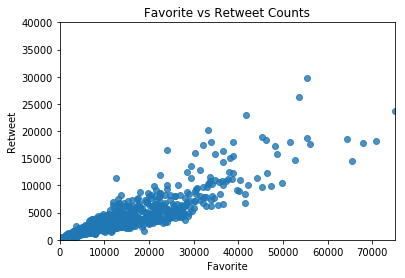

In [58]:
ax = sns.regplot(x="favorite_count", y="retweet_count", data=df, fit_reg=False)
plt.xlabel("Favorite")
plt.ylabel("Retweet")
plt.title("Favorite vs Retweet Counts") 
plt.ylim(0,40000)
plt.xlim(0,75000)
plt.show(ax)

From looking at the scatterplot, it seems that most of the tweets are around 0-30,000 favorites and 0-10,000 retweets. 

### Tweets vs. favorites, Year


In [59]:
df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'year', 'period',
       'jpg_url', 'dog_stage', 'retweet_count', 'favorite_count'],
      dtype='object')

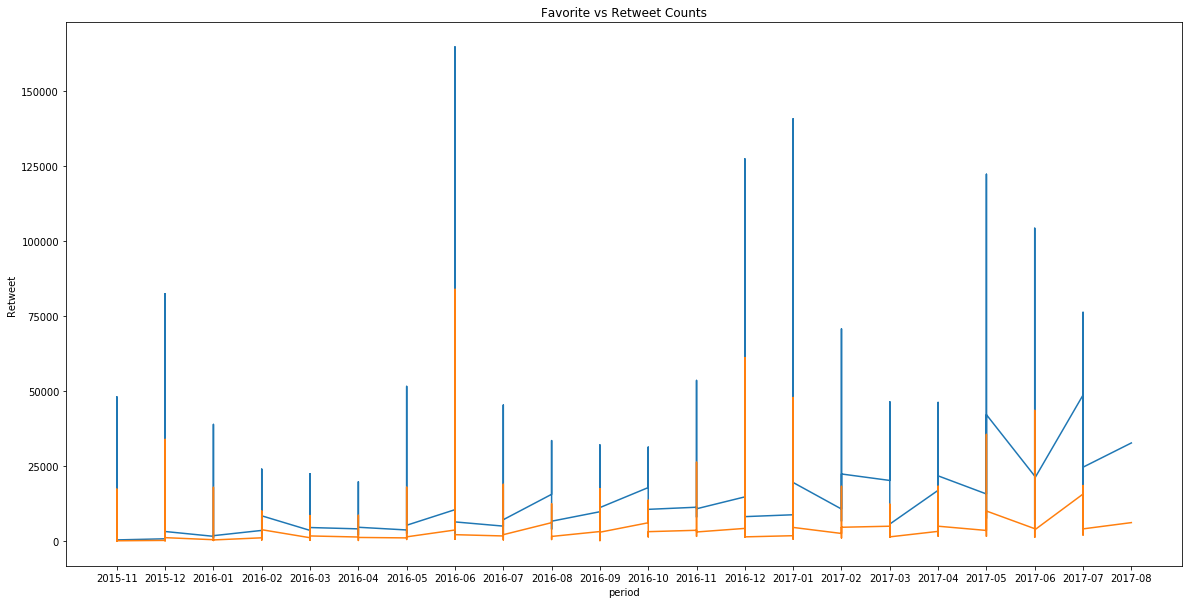

In [60]:
# fig, ax = plt.subplots()

# avg_fav = df.groupby('period')['favorite_count'].agg('mean')
# avg_rt = df.groupby('period')['retweet_count'].agg('mean')


# avg_fav_keys = pd.Series((df.groupby('period')['favorite_count'].agg('mean')).keys)
# avg_fav_values = pd.Series((df.groupby('period')['favorite_count'].agg('mean')).values)
# avg_rt_keys = pd.Series((df.groupby('period')['retweet_count'].agg('mean')).keys)
# avg_rt_values = pd.Series((df.groupby('period')['retweet_count'].agg('mean')).values)

# plt.figure(figsize=(20,10))
# plt.plot(avg_fav_keys,avg_fav_values)
# plt.plot(avg_rt_keys,avg_rt_values)

plt.figure(figsize=(20,10))
plt.plot(df.period,df.favorite_count)
plt.plot(df.period,df.retweet_count)


plt.xlabel("period")
plt.ylabel("Retweet")
plt.title("Favorite vs Retweet Counts")

plt.show()


# type(avg_fav_keys)
# # type(avg_fav_values)
# # pd.Series(avg_fav.keys)
# # avg_fav.values


June 2016, December 2016, and January 2017 had high spikes of tweets/favorites

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


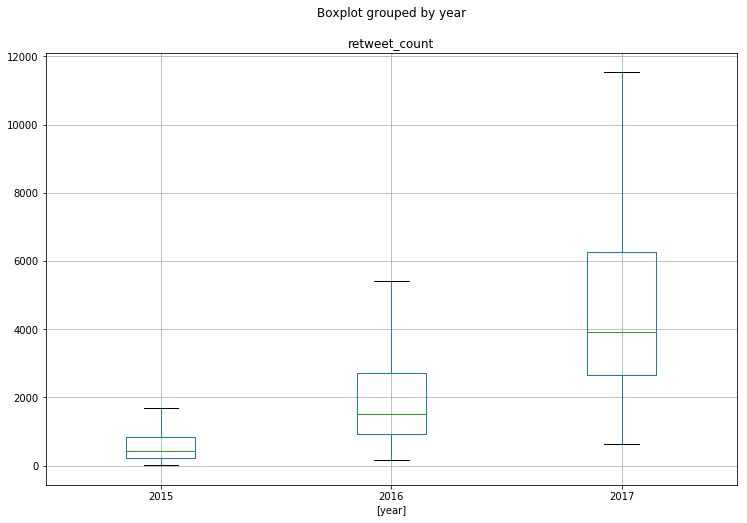

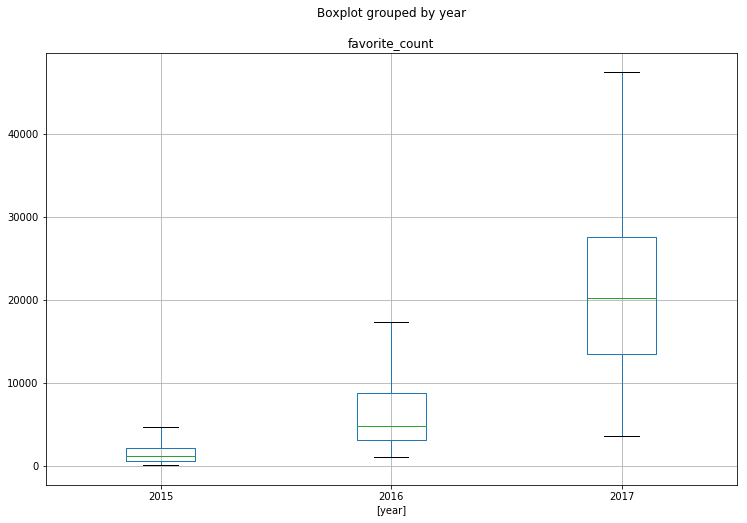

In [61]:
# boxplot = df.boxplot(column=['favorite_count', 'retweet_count'], by=['year'], showfliers=False, figsize=(16,8))
boxplot = df.boxplot(column=['retweet_count'], by=['year'], showfliers=False, figsize=(12,8))
boxplot = df.boxplot(column=['favorite_count'], by=['year'], showfliers=False, figsize=(12,8))

### Tweets vs. favorites, Dog type


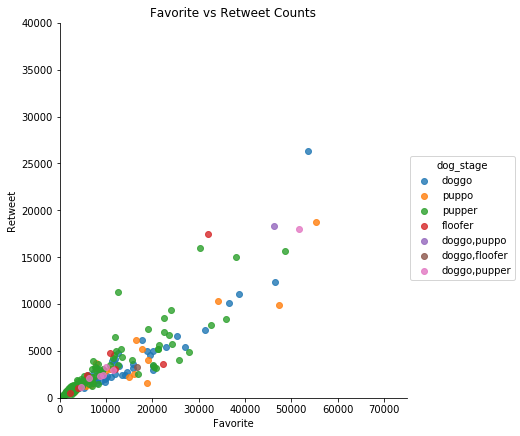

In [62]:
ax = sns.lmplot(x="favorite_count", y="retweet_count", data=df, hue='dog_stage', fit_reg=False, size=6 )
plt.xlabel("Favorite")
plt.ylabel("Retweet")
plt.title("Favorite vs Retweet Counts") 
plt.ylim(0,40000)
plt.xlim(0,75000)
plt.show(ax)

From looking at the scatterplot, it seems that most of the tweets are around 0-30,000 favorites and 0-10,000 retweets. 

/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


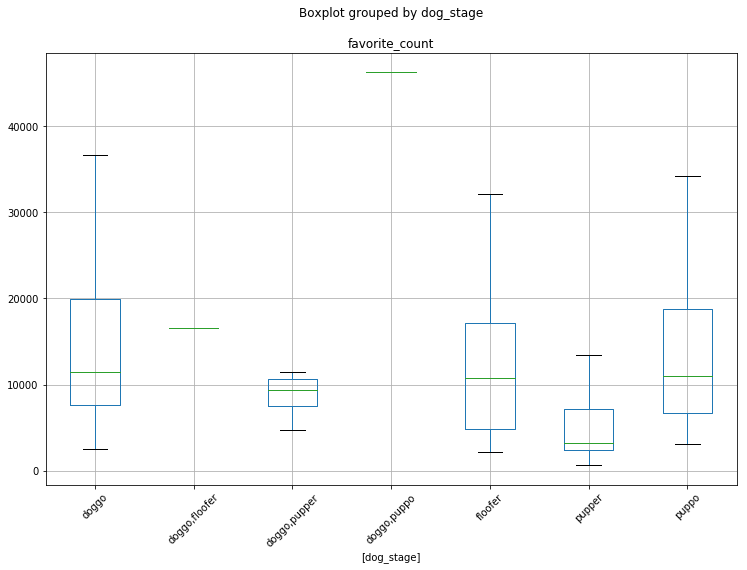

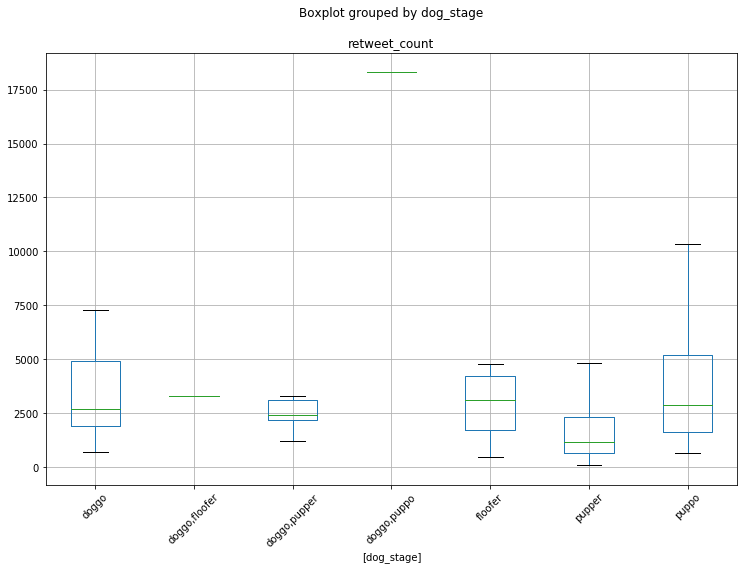

In [63]:
# boxplot = df.boxplot(column=['favorite_count', 'retweet_count'], by=['dog_stage'], showfliers=False, figsize=(16,8), rot=45)

boxplot = df.boxplot(column=['favorite_count'], by=['dog_stage'], showfliers=False, figsize=(12,8), rot=45)
boxplot = df.boxplot(column=['retweet_count'], by=['dog_stage'], showfliers=False, figsize=(12,8), rot=45)

Looking at the dog stages, doggo and poppu looks similar, and doggo.floofer and doggo.puppo seems to be one offs